# Data Science for Spatial Systems

### 芝加哥出租车用时和天气的关系 - 基于GPU加速的机器学习

### 数据导入

环境和包要求：
RAPIDS 24.04
CUDA 12.4
Python 3.11.8
Ubuntu 22.04


In [1]:
#数据导入
#包导入
%load_ext cudf.pandas
# pandas API is now automatically GPU accelerated

import pandas as pd
import cuml
import cupy as cp


In [2]:
import matplotlib.pyplot as plt



In [3]:
#在这里读取数据，但是需要后期改为github链接
# 加载第一个CSV文件
taxi = pd.read_csv('Taxi_Trips_-_2024_20240408.csv')
# 加载第二个CSV文件
weather = pd.read_csv('Chicago 2024-01-01 to 2024-03-01.csv')


In [4]:
#上面加一个taxi的head
weather.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,Chicago,2024-01-01T00:00:00,0.8,-5.1,-2.9,76.79,0.0,0,None,0.0,...,1021.1,100.0,16.0,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
1,Chicago,2024-01-01T01:00:00,0.8,-4.6,-3.0,76.14,0.0,0,None,0.0,...,1021.7,100.0,16.0,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
2,Chicago,2024-01-01T02:00:00,0.8,-4.6,-3.0,76.14,0.0,0,None,0.0,...,1022.5,100.0,13.6,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
3,Chicago,2024-01-01T03:00:00,0.4,-4.5,-2.5,80.46,0.0,0,None,0.0,...,1023.1,100.0,12.7,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
4,Chicago,2024-01-01T04:00:00,0.2,-5.4,-3.1,78.50,0.0,0,None,0.0,...,1023.6,100.0,14.7,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."


### 数据清洗和操作

记得开局设置每列的数据格式

##### 1. 数据的列中带有空格 2. 处理时间戳，从第一天开始设置日期 3. taxi数据和天气数据进行连接 4. 需要的列作为一个新的数据集（先不要，因为下面要做EDA）：trip start timestamp, trip seconds, trip miles, 

In [5]:
#清理Column中的空格，替换为_
taxi.columns = taxi.columns.str.replace(' ', '_')
taxi.head()

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location
0,0287f53fedcde6b0af9aab9e32cbd2cadb337eaa,e54db25f18193a08f1f5754515e8c338480e04fb938ed3...,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,15,0.09,NaN,NaN,8,8.0,...,35.0,38.75,Credit Card,City Service,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
1,1f0034299b914fd7b45002568576a353c83acb2f,4a263f78f56815be4acd38658af8fc1824ce4e15f7ec81...,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,900,3.00,NaN,NaN,24,8.0,...,0.0,12.00,Cash,Taxi Affiliation Services,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,01a0b77b722a0b91f45cb4fc90b3e64f76fd0681,4f1e94982e6851725add382f7981d64006ae7c38f3664f...,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,711,5.84,NaN,NaN,56,NaN,...,5.0,26.70,Credit Card,City Service,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),NaN,NaN,None
3,14aff2071ac81c6450a8f8b0e1534497da900197,de8e8659ceb9eb0da842a46b60c0a5207098ac69fc23ab...,03/01/2024 12:00:00 AM,03/01/2024 12:30:00 AM,1770,13.36,NaN,NaN,76,3.0,...,4.0,47.10,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
4,16d3a633e2f380cee4a7fa4677db163b6e91255d,d79d3e19a1d5f6cb0cd4449d5579412262a2f1b182799d...,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,849,6.13,NaN,NaN,8,3.0,...,0.0,22.82,Mobile,5 Star Taxi,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)


In [6]:
#处理时间戳

taxi['Trip_Start_Timestamp'] = pd.to_datetime(taxi['Trip_Start_Timestamp'])
weather['datetime'] = pd.to_datetime(weather['datetime'])

#创建基准日期（2024-01-01）
base_date = pd.to_datetime('2024-01-01')

#计算每个日期时间与基准日期之间的天数差
taxi['days_from_base'] = (taxi['Trip_Start_Timestamp'] - base_date).dt.days
weather['days_from_base'] = (weather['datetime'] - base_date).dt.days

#将日期时间向下舍入到一个整点小时，这是为了后面把时间对齐到小时级别
taxi['rounded_hour'] = taxi['Trip_Start_Timestamp'].dt.floor('H')
taxi['hour'] = taxi['rounded_hour'].dt.hour

weather['rounded_hour'] = weather['datetime'].dt.floor('H')
weather['hour'] = weather['rounded_hour'].dt.hour

/home/jax/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cudf/pandas/fast_slow_proxy.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return fn(*args, **kwargs)
/home/jax/miniconda3/envs/rapids-24.04/lib/python3.11/contextlib.py:81: FutureWarning: FutureWarning: H is deprecated and will be removed in a future version, please use h instead.
  return func(*args, **kwds)


In [7]:

taxi.sample(5)

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,days_from_base,rounded_hour,hour
551704,bdf5e783df137d18a6a1e75b36d1f575dadf6804,32aa143752e0ab419df8db4d44e341571c4cad6ddd1515...,2024-01-24 12:15:00,01/24/2024 12:30:00 PM,351,0.88,NaN,NaN,8,7.0,...,Blue Ribbon Taxi Association,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),23,2024-01-24 12:00:00,12
821947,4dfcd85ffdd34b6771dfbd7d684830fd23d3ca25,37fe4a4101f0bde1bfeedd12c8d33fc1c90401ce6a2589...,2024-01-04 14:45:00,01/04/2024 03:00:00 PM,1380,11.10,NaN,NaN,51,NaN,...,Taxi Affiliation Services,41.690633,-87.570058,POINT (-87.5700582686 41.6906333472),NaN,NaN,None,3,2024-01-04 14:00:00,14
631482,8f645d75198855e12188c79dcdd2cd1da6e21ea5,0996793cf5fd9c72087b8d7fb941ba2f54c51573885d44...,2024-01-19 12:45:00,01/19/2024 01:15:00 PM,1524,16.95,1.703198e+10,1.703132e+10,76,32.0,...,5 Star Taxi,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),18,2024-01-19 12:00:00,12
524533,b402557d428a448198da99b2b4071058b76e8a13,9d5308a039a77963ed44f4b4435abd45f28eb7c4eb7669...,2024-01-25 19:30:00,01/25/2024 08:30:00 PM,3068,7.24,NaN,NaN,2,7.0,...,Flash Cab,42.001571,-87.695013,POINT (-87.6950125892 42.001571027),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),24,2024-01-25 19:00:00,19
501263,1d9c2bcc65031cbcedeb3743abed302848ee240e,a46aedb114a720df392300b351493f1a65cd0e8f485f70...,2024-01-27 13:30:00,01/27/2024 01:45:00 PM,903,0.00,NaN,NaN,8,33.0,...,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.857184,-87.620335,POINT (-87.6203346241 41.8571838585),26,2024-01-27 13:00:00,13


In [8]:
weather.sample(5)

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,days_from_base,rounded_hour,hour
868,Chicago,2024-02-06 04:00:00,1.5,1.5,0.5,92.90,0.000,0,None,0.0,...,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665...",36,2024-02-06 04:00:00,4
1259,Chicago,2024-02-22 11:00:00,12.8,12.8,1.2,45.28,0.000,0,None,0.0,...,522,1.9,5,10,Partially cloudy,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,744665...",52,2024-02-22 11:00:00,11
767,Chicago,2024-02-01 23:00:00,3.5,-1.4,1.2,84.58,0.000,0,None,0.0,...,0,0.0,0,10,Partially cloudy,partly-cloudy-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",31,2024-02-01 23:00:00,23
140,Chicago,2024-01-06 20:00:00,1.0,-0.9,-0.2,91.68,0.264,100,"rain,snow",0.0,...,0,0.0,0,10,"Snow, Rain, Overcast",rain,"72534014819,KORD,KMDW,72530094846,F1983,744665...",5,2024-01-06 20:00:00,20
1382,Chicago,2024-02-27 14:00:00,22.3,22.3,13.5,57.39,0.000,0,None,0.0,...,265,1.0,3,30,Partially cloudy,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,744665...",57,2024-02-27 14:00:00,14


In [9]:
data = taxi.merge(weather, on=['days_from_base', 'hour'])

In [10]:
data.head()

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,rounded_hour_y
0,0287f53fedcde6b0af9aab9e32cbd2cadb337eaa,e54db25f18193a08f1f5754515e8c338480e04fb938ed3...,2024-03-01,03/01/2024 12:00:00 AM,15,0.09,NaN,NaN,8,8.0,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01
1,1f0034299b914fd7b45002568576a353c83acb2f,4a263f78f56815be4acd38658af8fc1824ce4e15f7ec81...,2024-03-01,03/01/2024 12:15:00 AM,900,3.00,NaN,NaN,24,8.0,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01
2,01a0b77b722a0b91f45cb4fc90b3e64f76fd0681,4f1e94982e6851725add382f7981d64006ae7c38f3664f...,2024-03-01,03/01/2024 12:00:00 AM,711,5.84,NaN,NaN,56,NaN,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01
3,14aff2071ac81c6450a8f8b0e1534497da900197,de8e8659ceb9eb0da842a46b60c0a5207098ac69fc23ab...,2024-03-01,03/01/2024 12:30:00 AM,1770,13.36,NaN,NaN,76,3.0,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01
4,16d3a633e2f380cee4a7fa4677db163b6e91255d,d79d3e19a1d5f6cb0cd4449d5579412262a2f1b182799d...,2024-03-01,03/01/2024 12:15:00 AM,849,6.13,NaN,NaN,8,3.0,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01


In [11]:
data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 865247 entries, 0 to 865246
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Trip_ID                     865247 non-null  object
 1   Taxi_ID                     865246 non-null  object
 2   Trip_Start_Timestamp        865247 non-null  datetime64[ns]
 3   Trip_End_Timestamp          865239 non-null  object
 4   Trip_Seconds                865078 non-null  int64
 5   Trip_Miles                  865241 non-null  float64
 6   Pickup_Census_Tract         327251 non-null  int64
 7   Dropoff_Census_Tract        313854 non-null  int64
 8   Pickup_Community_Area       842052 non-null  int64
 9   Dropoff_Community_Area      781394 non-null  int64
 10  Fare                        863202 non-null  float64
 11  Tips                        863202 non-null  float64
 12  Tolls                       863202 non-null  float64
 13  Extras                

In [12]:
print(data.columns)

Index(['Trip_ID', 'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
       'Trip_Seconds', 'Trip_Miles', 'Pickup_Census_Tract',
       'Dropoff_Census_Tract', 'Pickup_Community_Area',
       'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip_Total', 'Payment_Type', 'Company', 'Pickup_Centroid_Latitude',
       'Pickup_Centroid_Longitude', 'Pickup_Centroid_Location',
       'Dropoff_Centroid_Latitude', 'Dropoff_Centroid_Longitude',
       'Dropoff_Centroid__Location', 'days_from_base', 'rounded_hour_x',
       'hour', 'name', 'datetime', 'temp', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
       'icon', 'stations', 'rounded_hour_y'],
      dtype='object')


## EDA+筛选数据

### 清洗空值和列筛选

清除无意义的值和异常值，包括：
空值
trip miles>0是必须的
trip miles超长的
时速 > 30 miles/h的
trip seconds超长但是miles特别小的
pickup和dropoff centroids在芝加哥边界外的（如果有，当然也可以强行删除增加EDA丰富度）不好处理，算了
extras和tolls特别大的订单有几个是来自同几个taxi id，并且查看到它们的trip miles都很短，在1英里以下，且均为现金支付（现金较难追踪，可能与犯罪有关），因此有理由怀疑这是他们出于某种动机产生的虚假订单，所以删除

In [13]:
data.isnull().sum()

Trip_ID                            0
Taxi_ID                            1
Trip_Start_Timestamp               0
Trip_End_Timestamp                 8
Trip_Seconds                     169
Trip_Miles                         6
Pickup_Census_Tract           537996
Dropoff_Census_Tract          551393
Pickup_Community_Area          23195
Dropoff_Community_Area         83853
Fare                            2045
Tips                            2045
Tolls                           2045
Extras                          2045
Trip_Total                      2045
Payment_Type                       0
Company                            0
Pickup_Centroid_Latitude       22966
Pickup_Centroid_Longitude      22966
Pickup_Centroid_Location       22966
Dropoff_Centroid_Latitude      79675
Dropoff_Centroid_Longitude     79675
Dropoff_Centroid__Location     79675
days_from_base                     0
rounded_hour_x                     0
hour                               0
name                               0
d

一共有很多列有空值，我们只关注对我们有用的，并清除其中的空值，这包括：
'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
       'Trip_Seconds', 'Trip_Miles', 'Pickup_Community_Area',
       'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip_Total'

In [14]:
# 选择关注的列
columns_to_drop = [
    'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
    'Trip_Seconds', 'Trip_Miles', 'Pickup_Community_Area',
    'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
    'Trip_Total'
]

# 删除这些列中包含空值的行
data = data.dropna(subset=columns_to_drop)

重新组织data，只保留我们感兴趣的列：'Trip_ID', 'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
       'Trip_Seconds', 'Trip_Miles', 'Pickup_Community_Area',
       'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip_Total', 'Payment_Type', 'Company', 'days_from_base', 
       'hour', 'temp', 'feelslike', 'dew', 'humidity',
       'precip', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex'

In [15]:
#重新组织data

# 定义感兴趣的列
columns_of_interest = [
    'Trip_ID', 'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
    'Trip_Seconds', 'Trip_Miles', 'Pickup_Community_Area',
    'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
    'Trip_Total', 'Payment_Type', 'Company', 'days_from_base', 
    'hour', 'temp', 'feelslike', 'dew', 'humidity',
    'precip', 'snow', 'snowdepth', 'windgust',
    'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
    'solarradiation', 'solarenergy', 'uvindex'
]

# 使用这个列表过滤DataFrame，只保留感兴趣的列
data = data[columns_of_interest]

data.isnull().sum()


Trip_ID                   0
Taxi_ID                   0
Trip_Start_Timestamp      0
Trip_End_Timestamp        0
Trip_Seconds              0
Trip_Miles                0
Pickup_Community_Area     0
Dropoff_Community_Area    0
Fare                      0
Tips                      0
Tolls                     0
Extras                    0
Trip_Total                0
Payment_Type              0
Company                   0
days_from_base            0
hour                      0
temp                      0
feelslike                 0
dew                       0
humidity                  0
precip                    0
snow                      0
snowdepth                 0
windgust                  0
windspeed                 0
winddir                   0
sealevelpressure          0
cloudcover                0
visibility                0
solarradiation            0
solarenergy               0
uvindex                   0
dtype: int64

## 清理异常值

### Trip Miles

In [16]:
def simple_print_head(df, ignore_columns=['Trip_ID', 'Taxi_ID'], n=5):
    """
    打印DataFrame，忽略默认指定的列。
    
    参数:
    df : DataFrame
        需要打印的Pandas DataFrame。
    ignore_columns : list, optional
        要忽略的列的列表，默认忽略'Trip_ID'和'Taxi_ID'。
    num_rows : int, optional
        要打印的行数，默认为5。
    """
    
    # 计算要打印的列
    columns_to_print = [col for col in df.columns if col not in ignore_columns]
    
    # 打印指定行数的DataFrame，只包括选中的列
    return df[columns_to_print].head(n)


In [17]:
# 对'Trip_Miles'列进行降序排序
trip_miles_sorted = data.sort_values('Trip_Miles', ascending=False)

# 打印排序后的DataFrame
simple_print_head(trip_miles_sorted, n=10)

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Fare,Tips,Tolls,Extras,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
305972,2024-02-10 10:00:00,02/10/2024 05:45:00 PM,27853,3093.47,8,76,9999.75,0.0,0.0,0.0,...,0.0,27.7,15.4,318,1015.9,92.8,16.0,119,0.4,1
830273,2024-01-03 21:00:00,01/03/2024 09:00:00 PM,0,664.90,76,76,41.25,0.0,0.0,4.0,...,0.0,25.9,14.3,322,1021.6,100.0,16.0,0,0.0,0
553835,2024-01-24 10:30:00,01/24/2024 11:00:00 AM,1788,493.03,56,28,32.00,7.3,0.0,4.0,...,0.0,11.2,10.6,61,1021.3,100.0,5.9,26,0.1,0
613434,2024-01-20 17:45:00,01/20/2024 05:45:00 PM,60,244.20,57,57,8.85,0.0,0.0,0.0,...,0.0,20.5,16.4,289,1036.4,24.2,16.0,0,0.0,0
313016,2024-02-09 17:00:00,02/09/2024 05:15:00 PM,840,241.30,28,21,14.75,0.0,0.0,0.0,...,0.0,35.3,19.9,245,1007.7,24.2,16.0,7,0.0,0
786156,2024-01-07 19:45:00,01/07/2024 08:15:00 PM,1380,159.00,76,7,39.50,8.8,0.0,4.0,...,0.0,16.6,2.8,322,1020.8,100.0,16.0,0,0.0,0
737407,2024-01-11 10:00:00,01/11/2024 03:00:00 PM,18657,135.57,33,33,332.50,0.0,0.0,163.0,...,0.0,35.8,23.1,289,1009.1,100.0,16.0,86,0.3,1
445367,2024-01-31 16:45:00,01/31/2024 08:15:00 PM,12769,132.12,76,6,0.05,0.0,0.0,0.0,...,0.0,37.1,24.9,228,1019.1,97.5,16.0,32,0.1,0
720852,2024-01-12 11:45:00,01/12/2024 03:00:00 PM,11479,115.38,76,75,0.05,0.0,0.0,0.0,...,0.0,46.7,30.2,101,994.8,100.0,2.4,9,0.0,0
629335,2024-01-19 15:00:00,01/19/2024 06:00:00 PM,10953,114.21,76,15,266.75,0.0,0.0,103.0,...,2.6,38.9,25.5,299,1026.2,89.0,16.0,30,0.1,0


In [18]:
# 对'Trip_Miles'列进行降序排序
trip_miles_sorted = data.sort_values('Trip_Miles', ascending=True)

# 打印排序后的DataFrame
simple_print_head(trip_miles_sorted, n=10)

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Fare,Tips,Tolls,Extras,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
11,2024-03-01 00:00:00,03/01/2024 12:00:00 AM,180,0.0,24,7,11.25,0.00,0.0,0.0,...,0.0,34.8,21.1,191,1025.3,0.0,16.0,0,0.0,0
35,2024-03-01 00:00:00,03/01/2024 12:30:00 AM,1860,0.0,76,3,34.75,8.95,0.0,4.0,...,0.0,34.8,21.1,191,1025.3,0.0,16.0,0,0.0,0
40,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,6,0.0,8,8,8.00,2.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
45,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,13,0.0,8,8,3.25,0.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
50,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,2,0.0,6,6,40.00,0.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
52,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,12,0.0,76,76,3.25,0.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
53,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,9,0.0,24,24,18.00,3.70,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
66,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,0,0.0,32,32,35.00,7.10,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
95,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,7,0.0,28,28,55.00,5.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
118,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,0,0.0,76,76,3.25,0.00,0.0,4.5,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0


我们发现有一些非常大的trip miles，还有许多为0的，设置过滤条件 200>trip miles>0

In [19]:
# 应用过滤条件：选择Trip_Miles大于0且小于200的行
data = data[(data['Trip_Miles'] > 0) & (data['Trip_Miles'] < 200)]

### Trip Seconds超长的,trip seconds>0

In [20]:
# 对'Trip_Seconds'列进行降序排序
trip_seconds_sorted = data.sort_values('Trip_Seconds', ascending=False)

# 打印排序后的DataFrame
simple_print_head(trip_seconds_sorted, n=10)

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Fare,Tips,Tolls,Extras,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
747312,2024-01-10 15:30:00,01/11/2024 03:30:00 PM,86135,2.42,2,2,38.75,0.0,0.0,0.0,...,0.0,32.2,14.8,223,1003.7,100.0,16.0,19,0.1,0
824294,2024-01-04 12:30:00,01/05/2024 11:45:00 AM,83900,5.95,4,28,83.75,0.0,0.0,0.0,...,0.0,9.4,4.8,70,1028.3,24.2,16.0,62,0.2,1
259933,2024-02-13 19:00:00,02/14/2024 06:15:00 PM,83697,5.15,32,7,15.50,0.0,0.0,0.0,...,0.0,9.4,6.2,316,1020.6,24.2,16.0,0,0.0,0
393282,2024-02-04 13:30:00,02/05/2024 12:15:00 PM,81322,15.30,32,49,76.25,0.0,0.0,0.0,...,0.0,27.7,17.7,42,1018.3,44.0,16.0,93,0.3,1
325325,2024-02-08 19:45:00,02/09/2024 06:00:00 PM,80244,1.62,16,17,9.75,2.0,0.0,0.0,...,0.0,55.5,20.0,162,1003.7,93.0,16.0,0,0.0,0
524038,2024-01-25 20:00:00,01/26/2024 06:15:00 PM,79418,22.52,7,21,69.75,0.0,0.0,0.0,...,0.0,16.6,19.1,43,1015.2,100.0,4.8,0,0.0,0
756644,2024-01-09 23:30:00,01/10/2024 09:15:00 PM,78165,35.50,6,28,113.00,0.0,0.0,0.0,...,0.0,50.2,25.7,319,986.2,100.0,5.0,0,0.0,0
603065,2024-01-21 14:45:00,01/22/2024 12:30:00 PM,78067,3.86,76,24,12.00,0.0,0.0,6.0,...,0.0,38.9,19.5,192,1034.2,78.4,16.0,144,0.5,1
54364,2024-02-26 23:45:00,02/27/2024 09:15:00 PM,77907,6.93,77,76,25.25,0.0,0.0,0.0,...,0.0,40.0,22.6,189,998.0,78.4,16.0,0,0.0,0
401663,2024-02-03 16:00:00,02/04/2024 01:45:00 PM,77901,3.94,7,24,14.50,0.0,0.0,0.0,...,0.0,16.6,18.1,63,1018.8,50.2,14.9,39,0.1,0


In [21]:
# 对'Trip_Seconds'列进行升序排序
trip_seconds_sorted = data.sort_values('Trip_Seconds', ascending=True)

# 打印排序后的DataFrame
simple_print_head(trip_seconds_sorted, n=10)

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Fare,Tips,Tolls,Extras,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
514,2024-02-29 22:45:00,02/29/2024 10:45:00 PM,0,17.2,8,8,43.00,0.0,0.0,0.0,...,0.0,36.9,22.3,190,1026.3,0.0,16.0,0,0.0,0
962,2024-02-29 22:00:00,02/29/2024 10:00:00 PM,0,0.1,56,56,3.25,0.0,0.0,0.0,...,0.0,36.9,22.3,190,1026.3,0.0,16.0,0,0.0,0
1328,2024-02-29 21:30:00,02/29/2024 09:30:00 PM,0,1.5,41,41,7.25,0.0,0.0,1.0,...,0.0,36.6,20.5,188,1026.5,0.0,16.0,0,0.0,0
1571,2024-02-29 21:15:00,02/29/2024 09:15:00 PM,0,15.1,8,8,0.00,0.0,0.0,4.0,...,0.0,36.6,20.5,188,1026.5,0.0,16.0,0,0.0,0
1604,2024-02-29 21:00:00,02/29/2024 09:00:00 PM,0,8.1,42,42,22.50,0.0,0.0,0.0,...,0.0,36.6,20.5,188,1026.5,0.0,16.0,0,0.0,0
1677,2024-02-29 21:00:00,02/29/2024 09:00:00 PM,0,1.5,7,7,7.00,0.0,0.0,1.0,...,0.0,36.6,20.5,188,1026.5,0.0,16.0,0,0.0,0
2090,2024-02-29 20:30:00,02/29/2024 08:30:00 PM,0,0.1,51,51,3.25,0.0,0.0,0.0,...,0.0,38.9,20.7,188,1026.5,0.0,16.0,0,0.0,0
3967,2024-02-29 19:00:00,02/29/2024 07:00:00 PM,0,9.4,73,73,25.25,0.0,0.0,0.0,...,0.0,37.1,18.4,181,1026.7,0.0,16.0,0,0.0,0
4130,2024-02-29 18:45:00,02/29/2024 06:45:00 PM,0,0.4,8,8,4.75,1.0,0.0,0.0,...,0.0,43.1,20.2,198,1027.0,24.2,16.0,0,0.0,0
4228,2024-02-29 18:45:00,02/29/2024 06:45:00 PM,0,13.0,56,56,34.75,0.0,0.0,4.0,...,0.0,43.1,20.2,198,1027.0,24.2,16.0,0,0.0,0


我们可以看到有一些Trip Seconds非常大，但是Trip Miles都很短，并且订单时间大多在夜晚，一个猜想是司机休息时忘记关闭直到下一个订单结束或开启，总之，我们设置过滤条件 36000 > Trip Seconds >0

In [22]:
# 应用过滤条件：选择Trip_Miles大于0且小于36000的行
data = data[(data['Trip_Seconds'] > 0) & (data['Trip_Seconds'] < 36000)]

### 时速>30的

Text(0, 0.5, 'Frequency')

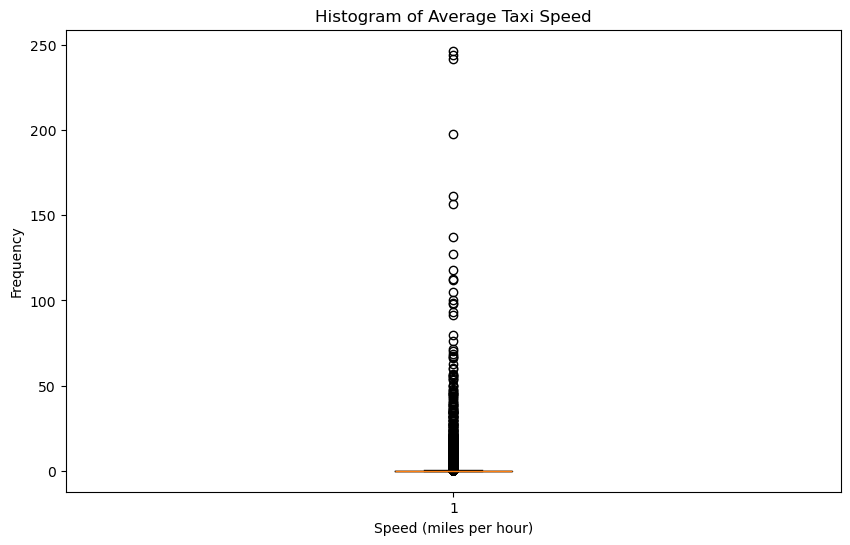

In [23]:
# 计算平均时速
data['Average_Speed'] = (data['Trip_Seconds'] / 3600) / data['Trip_Miles']

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.boxplot(data['Average_Speed'])
plt.title('Histogram of Average Taxi Speed')
plt.xlabel('Speed (miles per hour)')
plt.ylabel('Frequency')

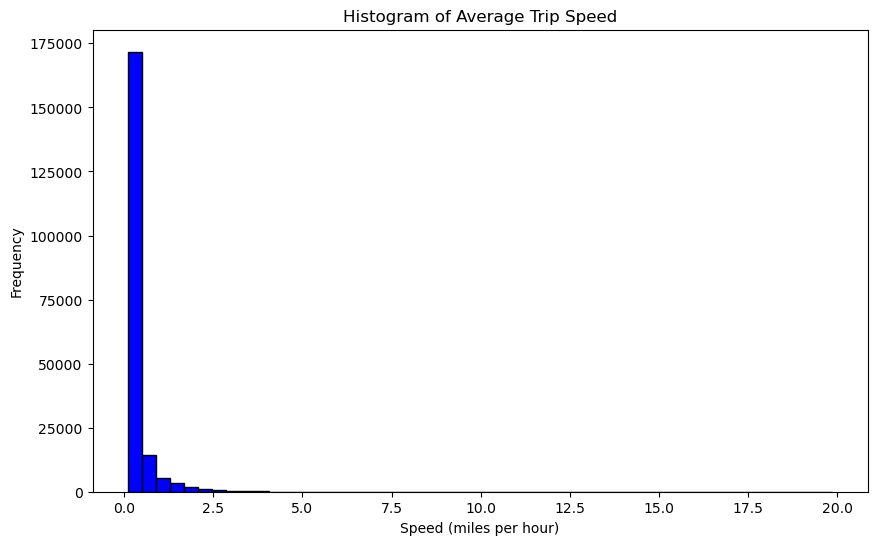

In [24]:
# 过滤掉'Trip_Seconds'和'Trip_Miles'为0的行以及平均时速超过30，小于0.1的行
data = data[(data['Average_Speed'] <= 20) & (data['Average_Speed'] >= 0.1)]

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(data['Average_Speed'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Average Trip Speed')
plt.xlabel('Speed (miles per hour)')
plt.ylabel('Frequency')

# 显示图表
plt.show()

#不想保留Speed列，丢弃它
data.drop('Average_Speed', axis=1, inplace=True)

### 费用不正常的也删了，每公里费用官方为2.25，trip totals/trip miles>=2的，（芝加哥官方发布的价格为base fare 3.25）https://www.chicago.gov/content/dam/city/depts/bacp/publicvehicleinfo/Chicabs/chicagotaxiplacard20200629.pdf

In [25]:
# 过滤掉'Trip_Total'小于3.25的行
data = data[
    (data['Trip_Total'] >= 3.25) &
    ((data['Trip_Total'] / data['Trip_Miles']) >= 2)
]

In [26]:
# 对'Trip_Total'列进行降序排序
trip_total_sorted = data.sort_values('Trip_Total', ascending=False)

# 创建一个包括'Trip_ID', 'Taxi_ID', 'Trip_End_Timestamp'的列列表
columns_to_include = ['Taxi_ID', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip_Total', 'Payment_Type']
columns_to_print = [col for col in trip_total_sorted.columns if col  in columns_to_include]

trip_total_sorted[columns_to_print].head(10)

,Taxi_ID,Fare,Tips,Tolls,Extras,Trip_Total,Payment_Type
648415,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,23.25,0.0,4444.44,4444.44,8912.13,Cash
25545,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,12.00,0.0,4444.44,4445.44,8901.88,Cash
436737,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,12.75,0.0,4444.44,4444.44,8901.63,Cash
128821,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,8.25,0.0,4444.44,4444.44,8897.13,Cash
110688,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,15.00,0.0,3333.33,3334.33,6682.66,Cash
721642,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,13.75,0.0,3333.33,3333.33,6680.41,Cash
815579,b96f0ba0e44d7ebbd86bcd1a4e7c527f21cc512f511bae...,10.00,0.0,0.00,4890.00,4900.00,Cash
147307,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,11.25,0.0,0.89,4431.67,4443.81,Cash
141224,bba5f37ade350fb6c866cabf5b33ba4511258aab201707...,2000.00,0.0,0.00,0.00,2000.00,Cash
279275,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,15.50,0.0,555.55,1142.36,1713.41,Cash


可以看出Trip Total高的数据在Tolls和Extras有非正常值，且来源于同一个Taxi_ID, 因此，我们将这些值都过滤掉，设置Trip_Total <1000

In [27]:
# 应用过滤条件：选择Trip_Total小于1000的行
data = data[data['Trip_Total'] < 1000]

### 接下来进行对Extras的探索

In [28]:
# 对'Extras'列进行降序排序
trip_tolls_sorted = data.sort_values('Extras', ascending=False)

# 创建一个包括'Trip_ID', 'Taxi_ID', 'Trip_End_Timestamp'的列列表
columns_to_include = ['Trip_Seconds', 'Trip_Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip_Total', 'Payment_Type']
columns_to_print = [col for col in trip_total_sorted.columns if col in columns_to_include]

trip_tolls_sorted[columns_to_print].head(100)

,Trip_Seconds,Trip_Miles,Fare,Tips,Tolls,Extras,Trip_Total,Payment_Type
486679,1200,0.60,25.75,0.0,0.0,448.40,474.15,Cash
42250,390,0.55,5.75,0.0,0.0,150.00,155.75,Cash
404038,24,0.01,3.25,28.1,0.0,136.75,168.60,Credit Card
638966,73,0.03,3.50,0.0,0.0,99.50,103.00,Cash
800530,16,0.03,3.25,0.0,0.0,97.00,100.75,Credit Card
...,...,...,...,...,...,...,...,...
434867,1800,0.80,36.50,10.0,0.0,42.00,88.50,Credit Card
528854,1560,2.30,14.00,4.0,0.0,42.00,60.00,Credit Card
533895,1920,0.80,37.00,10.0,0.0,42.00,89.00,Credit Card
823007,11820,0.90,47.00,10.0,0.0,42.00,99.00,Credit Card


据我们发现，许多Extras对应的是非常小的Trip_Miles,所以我们把Extras>10时Trip Miles<1的都删除

In [29]:
# 应用过滤条件：删除Extras > 10且Trip Miles < 1的行
data = data[~((data['Extras'] > 10) & (data['Trip_Miles'] < 1))]

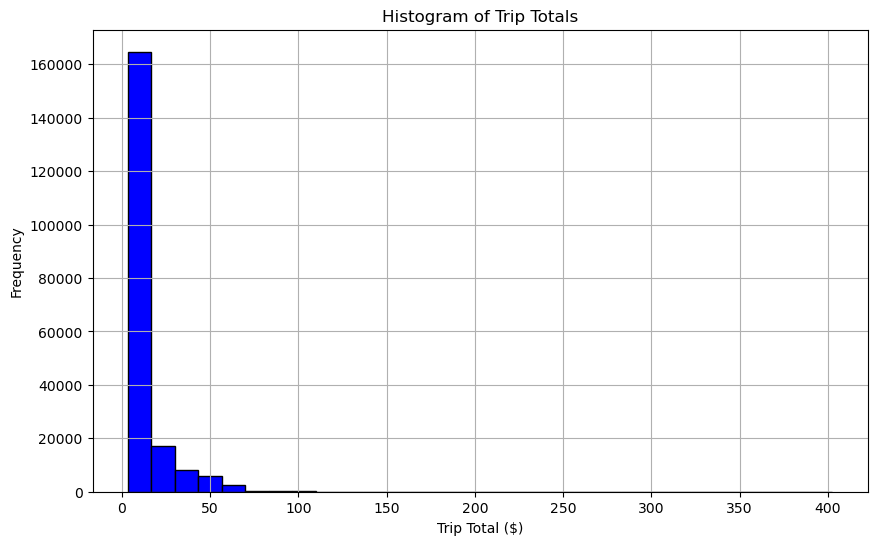

In [30]:
# 绘制直方图来观察'Trip_Total'列
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.hist(data['Trip_Total'], bins=30, color='blue', edgecolor='black')  # 设置bins数量和颜色
plt.title('Histogram of Trip Totals')  # 设置图形标题
plt.xlabel('Trip Total ($)')
plt.ylabel('Frequency')
plt.grid(True)  # 添加网格线

# 显示图表
plt.show()

通过上面对数据集详尽的分析和处理，我们可以认为我们拥有了一个较为体面的Taxi数据集，因此，我们从中选取我们接下来要进行分析的列：'Trip_Seconds', 'Trip_Miles','days_from_base', 'hour', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex'

In [31]:
# 定义我们要保留的列
columns_to_keep = [
    'Trip_Seconds', 'Trip_Miles', 'days_from_base', 'hour', 'temp', 
    'feelslike', 'dew', 'humidity', 'precip', 'snow', 'snowdepth', 
    'windgust', 'windspeed', 'winddir', 'sealevelpressure', 
    'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex'
]

# 更新data，只包含这些列
data = data[columns_to_keep]

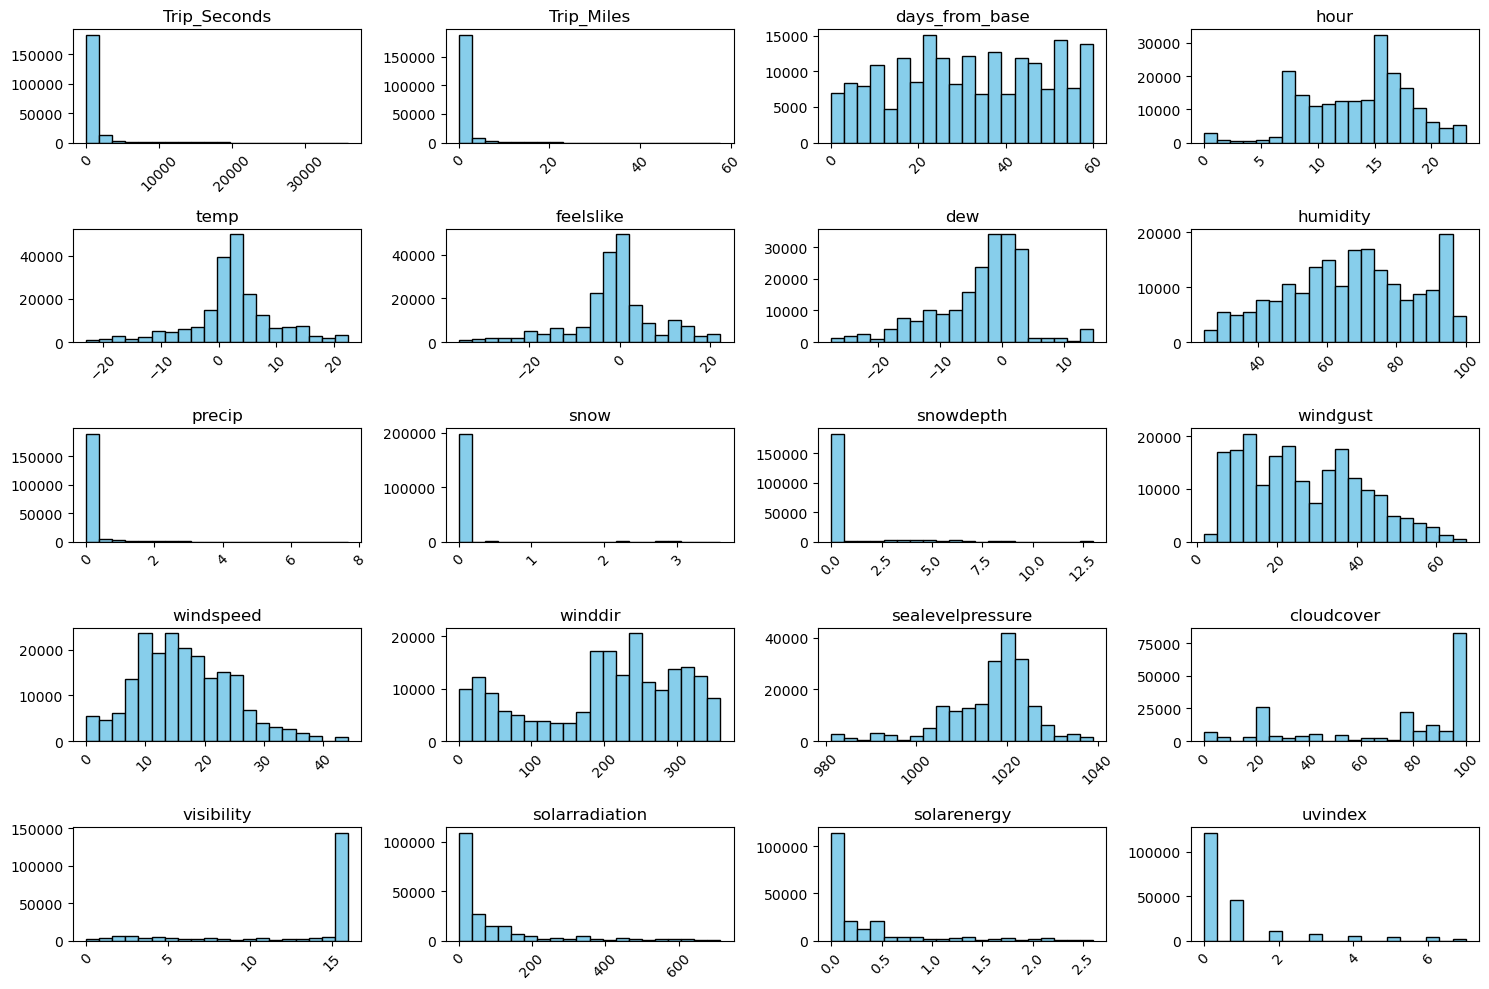

In [32]:
#打印一下数据分布

# 设置画布大小
plt.figure(figsize=(15, 10))

# 绘制每个变量的直方图
for index, column in enumerate(columns_to_keep):
    plt.subplot(5, 4, index + 1)  # 5行4列的网格，当前索引位置
    plt.hist(data[column].dropna(), bins=20, color='skyblue', edgecolor='black')  # 对每个列使用dropna()确保不计算NaN值
    plt.title(column)
    plt.xticks(rotation=45)  # 旋转X轴标签以更好地显示
    plt.tight_layout()  # 调整每个子图的布局

# 显示图表
plt.show()

## Variables(在这里做一个Table解释变量对应的含义，或者移到最前面)

In [33]:
data.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 199288 entries, 10 to 865246
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Trip_Seconds      199288 non-null  int64
 1   Trip_Miles        199288 non-null  float64
 2   days_from_base    199288 non-null  int64
 3   hour              199288 non-null  int16
 4   temp              199288 non-null  float64
 5   feelslike         199288 non-null  float64
 6   dew               199288 non-null  float64
 7   humidity          199288 non-null  float64
 8   precip            199288 non-null  float64
 9   snow              199288 non-null  float64
 10  snowdepth         199288 non-null  float64
 11  windgust          199288 non-null  float64
 12  windspeed         199288 non-null  float64
 13  winddir           199288 non-null  int64
 14  sealevelpressure  199288 non-null  float64
 15  cloudcover        199288 non-null  float64
 16  visibility        199288 non-null 

## 线性回归

## PCA

## RF， XGBoost等机器学习及其交叉验证

## 模型解释